# Data Fit Check

To check whether a dataset is applicable for linear regression, you need to assess if it meets the key assumptions of linear regression and if the relationship between the features and the target is reasonably linear. 

Here's a step-by-step checklist with explanation and how to perform each step in Python:

| Step | What to Check              | Method                              |
|------|----------------------------|-------------------------------------|
| 1    | Linearity                  | Scatterplot, residual plot          |
| 2    | Independence               | Durbin-Watson test                  |
| 3    | Homoscedasticity           | Residuals vs. fitted plot           |
| 4    | Normality of residuals     | QQ plot, Shapiro test               |
| 5    | No multicollinearity       | VIF                                 |
| 6    | Outliers / Influential pts (Optional) | Influence plot, Cook’s distance     |
| 7    | Good predictive power (Optional)      | R², RMSE, Cross-validation          |

In [59]:
# Sample data
import pandas as pd
import numpy as np

# Seed for reproducibility
np.random.seed(42)

# Create features with multicollinearity
n = 100
X1 = np.random.normal(0, 1, n)
X2 = 2 * X1 + np.random.normal(0, 0.1, n)  # Highly correlated with X1
X3 = np.random.normal(0, 1, n)             # Independent
y = np.random.normal(3, 10, n)

df = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'y': y
})

df.head()

,X1,X2,X3,y
0,0.496714,0.851891,0.357787,-5.289950
1,-0.138264,-0.318593,0.560785,-2.601810
2,0.647689,1.261106,1.083051,10.472936
3,1.523030,2.965832,1.053802,9.103703
4,-0.234153,-0.484435,-1.377669,2.790984


## 1. Linearity – Is the relationship linear?
What to check: Does the dependent variable change linearly with the predictors?

How to check:
- Scatter plot of each feature vs. target.
- Residual plot (residuals should not show patterns).

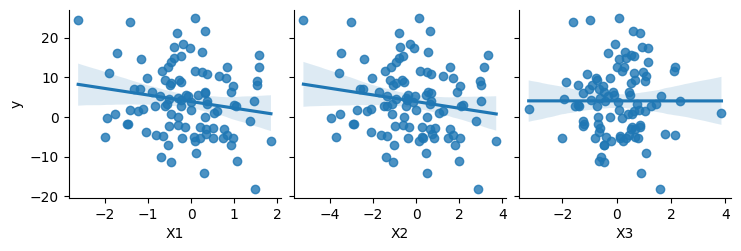

In [60]:
import seaborn as sns

sns.pairplot(df, x_vars=['X1', 'X2', 'X3'], y_vars='y', kind='reg')

##  2. Independence of Errors
What to check: Residuals should not be correlated with each other.

How to check: Especially important in time series – use the Durbin-Watson test.

In [61]:
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

X = df[['X1', 'X2', 'X3']].copy()
y = df.y.copy()

model = sm.OLS(y, sm.add_constant(X)).fit()
dw_stat = durbin_watson(model.resid)

print("Durbin-Watson:", dw_stat)  # ~2 is ideal; <1 or >3 is bad

Durbin-Watson: 1.8212831822413225


## 3. Homoscedasticity – Constant variance of errors
What to check: The spread of residuals should be roughly the same across all predicted values.

How to check: Plot residuals vs. fitted values.

Text(0.5, 1.0, 'Residuals vs Fitted')

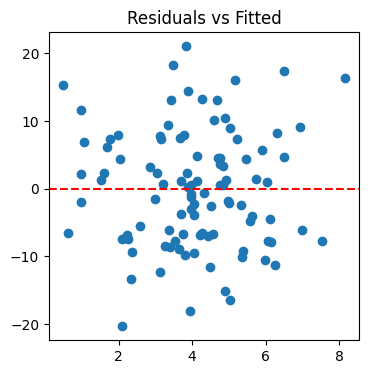

In [62]:
import matplotlib.pyplot as plt

fitted_vals = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(4, 4))
plt.scatter(fitted_vals, residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title("Residuals vs Fitted")

## 4. Normality of Errors
What to check: Are residuals normally distributed?

How to check: Use QQ plot, histogram of residuals, Shapiro test

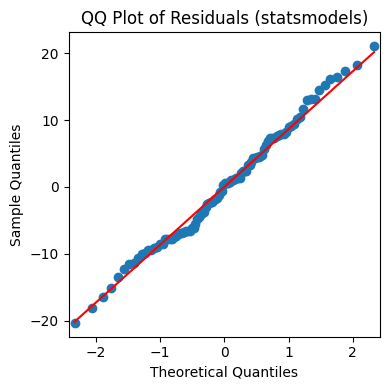

In [63]:
import statsmodels.api as sm

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
sm.qqplot(residuals, line='s', ax=ax) # line='45', 's', or 'q'
plt.title("QQ Plot of Residuals (statsmodels)")
plt.tight_layout()
plt.show()

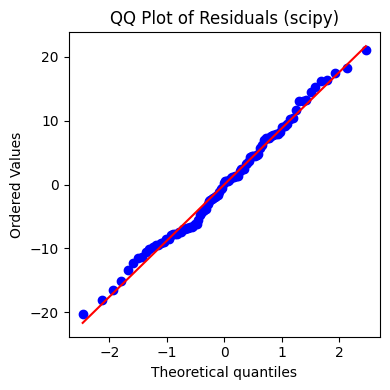

In [64]:
import scipy.stats as stats

plt.figure(figsize=(4, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (scipy)")
plt.tight_layout()
plt.show()


The **Shapiro-Wilk test** is a statistical test used to check whether a set of data (typically residuals) is normally distributed.

- Null hypothesis 𝐻0: The data comes from a normal distribution.
- Alternative hypothesis 𝐻1: The data does not come from a normal distribution.

In [65]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk test statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value > 0.05:
    print("✅ Residuals look normally distributed (fail to reject H₀)")
else:
    print("❌ Residuals are likely not normal (reject H₀)")

Shapiro-Wilk test statistic: 0.9891
P-value: 0.5933
✅ Residuals look normally distributed (fail to reject H₀)


## 5. No Multicollinearity
What to check: Are predictors highly correlated with each other?

How to check: Use VIF (Variance Inflation Factor).

| VIF 值范围   | 含义                                      |
|--------------|-------------------------------------------|
| = 1          | 没有共线性                                |
| 1 ~ 5        | 轻微共线性，可以接受                      |
| > 5          | 中度共线性，需要关注                      |
| > 10         | 严重共线性，可能影响模型稳定性和解释力   |

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_const = sm.add_constant(X)
vif = pd.DataFrame()
vif["Variable"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif)

  Variable         VIF
0    const    1.020278
1       X1  365.506565
2       X2  365.387996
3       X3    1.037920


## 6. Check Outliers and Leverage Points
Why: Outliers can distort model accuracy.

How: Use influence plot or Cook’s distance.

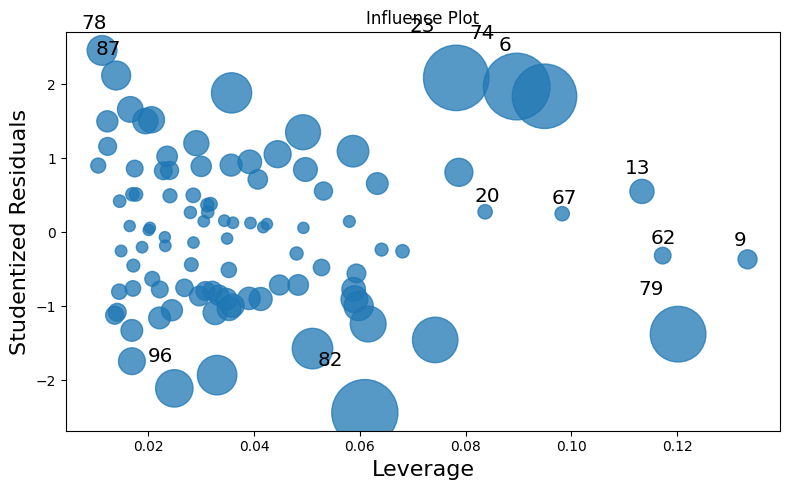

In [67]:
fig, ax = plt.subplots(figsize=(8, 5))
sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
plt.title("Influence Plot")
plt.tight_layout()
plt.show()

## 7. Model Performance
- $𝑅^2$, adjusted $𝑅^2$, MAE/MSE/RMSE for prediction quality.
- Use cross-validation to check model generalization.

In [68]:
from sklearn.metrics import r2_score, root_mean_squared_error

y_pred = model.predict(sm.add_constant(X))
print("R^2:", r2_score(y, y_pred))
print("RMSE:", root_mean_squared_error(y, y_pred))

R^2: 0.03172501693818863
RMSE: 8.656035707502237
